# DESAFIO Previsão temporal - preços da bolsa de valores

## Importando bibliotecas

In [1]:
# Importacao desta lib para desativar erro no TensorFlow
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [2]:
import numpy as np
import pandas as pd
import matplotlib
import tensorflow as tf
import sklearn

2024-12-10 17:16:55.810103: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-10 17:16:55.813570: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-10 17:16:55.860695: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-10 17:16:56.726381: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
np.__version__, pd.__version__, tf.__version__, matplotlib.__version__, sklearn.__version__

('1.26.4', '2.2.2', '2.16.1', '3.8.4', '1.4.2')

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

## Carregamento base de dados

In [64]:
base = pd.read_csv('petr4_treinamento_ex.csv')
base

,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-01-02,19.990000,20.209999,19.690001,19.690001,18.086271,30182600.0
1,2013-01-03,19.809999,20.400000,19.700001,20.400000,18.738441,30552600.0
2,2013-01-04,20.330000,20.620001,20.170000,20.430000,18.766001,36141000.0
3,2013-01-07,20.480000,20.670000,19.950001,20.080000,18.444506,28069600.0
4,2013-01-08,20.110001,20.230000,19.459999,19.500000,17.911745,29091300.0
...,...,...,...,...,...,...,...
1340,2018-05-21,26.100000,26.290001,24.940001,25.049999,25.000000,75971900.0
1341,2018-05-22,24.809999,25.290001,24.150000,24.709999,24.709999,88109900.0
1342,2018-05-23,24.230000,24.480000,23.270000,23.270000,23.270000,74622500.0
1343,2018-05-24,20.049999,20.750000,19.650000,20.080000,20.080000,240343800.0


## Verificar se há dados faltantes na base de dados

In [65]:
base.isnull().sum()

Date         0
Open         3
High         3
Low          3
Close        3
Adj Close    3
Volume       3
dtype: int64

In [66]:
base = base.dropna()

In [67]:
base.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [68]:
base_treinamento = base.iloc[:, 1:2].values

## Normalização dos dados - escalonamento

In [69]:
normalizador = MinMaxScaler(feature_range = (0, 1))
base_treinamento_normalizada = normalizador.fit_transform(base_treinamento)


## Separacao base de previsores e alvo com base nos ultimos 90 registros

In [70]:
previsores = []
preco_real = []
for i in range(90, 1242):
    previsores.append(base_treinamento_normalizada[i-90:i, 0])
    preco_real.append(base_treinamento_normalizada[i, 0])
previsores, preco_real = np.array(previsores), np.array(preco_real)
previsores = np.reshape(previsores, (previsores.shape[0], previsores.shape[1], 1))

In [71]:
previsores.shape

(1152, 90, 1)

In [72]:
preco_real.shape

(1152,)

## Estrutura da Rede Neural

In [73]:
regressor = Sequential()
regressor.add(LSTM(units = 100, return_sequences = True, input_shape = (previsores.shape[1], 1)))
regressor.add(Dropout(0.3))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

regressor.add(Dense(units = 1, activation = 'linear'))

/home/lucas/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [74]:
regressor.compile(optimizer='rmsprop',loss='mean_squared_error',metrics=['mean_absolute_error'])

In [75]:
regressor.fit(previsores, preco_real, epochs = 100, batch_size = 32)

Epoch 1/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 74ms/step - loss: 0.0461 - mean_absolute_error: 0.1557
Epoch 2/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - loss: 0.0109 - mean_absolute_error: 0.0836
Epoch 3/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - loss: 0.0095 - mean_absolute_error: 0.0764
Epoch 4/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - loss: 0.0080 - mean_absolute_error: 0.0698
Epoch 5/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - loss: 0.0082 - mean_absolute_error: 0.0696
Epoch 6/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - loss: 0.0069 - mean_absolute_error: 0.0651
Epoch 7/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - loss: 0.0059 - mean_absolute_error: 0.0577
Epoch 8/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - loss: 0.0054 - mean_absolute_error: 0.0562
Epoch 9/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 6s 96ms/step - loss: 0.0045 - mean_absolute_error: 0.0518
Epoch 10/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - loss: 0.0046 - mean_absolute_error: 0.0506
Epoch 11/100
36/36 ━━━━━━━━━━

## Previsoes com Base de Teste

In [76]:
base_teste = pd.read_csv('petr4_teste_ex.csv')
base_teste

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-05-28,19.200001,19.200001,16.910000,16.910000,16.910000,134504900
1,2018-05-29,18.000000,19.440001,17.600000,19.299999,19.299999,181509800
2,2018-05-30,18.389999,19.969999,18.129999,18.980000,18.980000,125430000
3,2018-06-01,19.559999,19.750000,14.900000,16.160000,16.160000,216954700
4,2018-06-04,17.290001,17.639999,17.049999,17.530001,17.530001,93547600
5,2018-06-05,17.360001,17.799999,16.590000,16.590000,16.590000,67006400
6,2018-06-06,16.469999,16.680000,15.870000,16.330000,16.330000,69496800
7,2018-06-07,16.000000,16.160000,14.930000,15.760000,15.760000,118752700
8,2018-06-08,15.810000,16.190001,15.060000,15.250000,15.250000,91461500
9,2018-06-11,15.500000,15.800000,15.130000,15.410000,15.410000,44872500


In [77]:
base_teste.shape

(19, 7)

In [78]:
preco_real_teste = base_teste.iloc[:, 1:2].values
preco_real_teste

array([[19.200001],
       [18.      ],
       [18.389999],
       [19.559999],
       [17.290001],
       [17.360001],
       [16.469999],
       [16.      ],
       [15.81    ],
       [15.5     ],
       [15.48    ],
       [15.42    ],
       [15.33    ],
       [15.03    ],
       [14.77    ],
       [14.26    ],
       [15.84    ],
       [16.09    ],
       [15.41    ]])

In [79]:
base_completa = pd.concat((base['Open'], base_teste['Open']), axis = 0)
entradas = base_completa[len(base_completa) - len(base_teste) - 90:].values
entradas = entradas.reshape(-1,1)
entradas = normalizador.transform(entradas)

In [82]:
len(entradas)

109

In [83]:
X_teste = []
for i in range(90, len(entradas)):
    X_teste.append(entradas[i-90:i, 0])
X_teste = np.array(X_teste)
X_teste = np.reshape(X_teste, (X_teste.shape[0], X_teste.shape[1], 1))

In [84]:
previsoes.mean()
preco_real_teste.mean()

16.379473684210524

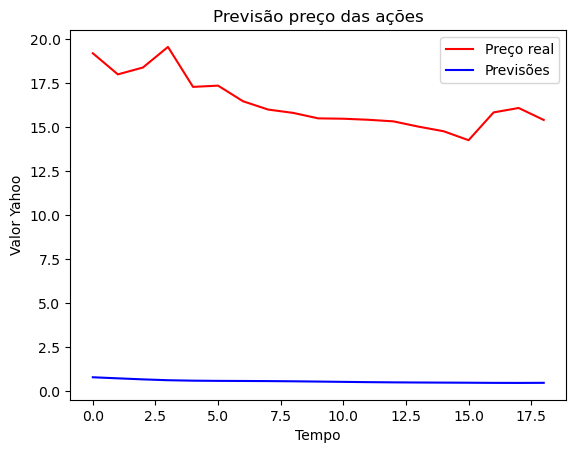

In [85]:
plt.plot(preco_real_teste, color = 'red', label = 'Preço real')
plt.plot(previsoes, color = 'blue', label = 'Previsões')
plt.title('Previsão preço das ações')
plt.xlabel('Tempo')
plt.ylabel('Valor Yahoo')
plt.legend()
plt.show()